In [1]:
import tensorflow as tf
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
import numpy as np
from scipy.special import softmax
from transformers import pipeline
import pandas as pd
import re

2024-04-22 14:18:58.788851: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df0 = pd.read_csv("yelp_reviews_new.csv")
df1 = pd.read_csv("yelp_reviews.csv")
df = pd.concat([df0,df1])
df.drop(['Unnamed: 0','res_url'], axis=1, inplace=True)

In [3]:
df['points'].value_counts().sum()

4104

In [4]:
def lab_function(row):
    if row['points'] == '5 star rating' :
        return 1
    elif row['points'] == '4 star rating' :
        return 1
    elif row['points'] == '3 star rating' :
        return 0
    elif row['points'] == '2 star rating' :
        return -1
    elif row['points'] == '1 star rating' :
        return -1
    

df['label'] = df.apply(lambda x: lab_function(x),axis=1)
df.drop('points', axis=1,inplace=True)

In [5]:
df['cleaned_text'] = df.apply(lambda x: re.sub('[^a-zA-Z1-9 ]','',str(x.res_reviews)).lower(),axis=1)
df.drop('res_reviews',axis=1,inplace=True)

In [6]:
df.head()

,label,cleaned_text
0,1,marcos was great the vibe was nice and he help...
1,1,best place in la for micheladas staff is great...
2,1,edgar was great very knowledgeable with his be...
3,1,oooo their micheladas are so yummy the food is...
4,0,this spot is actually super cute they have an ...


## Down sampling

In [34]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(df[['cleaned_text']], df[['label']])

In [7]:
# No down sampling
X_res = df[['cleaned_text']]
y_res = df[['label']]

In [8]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
#model.save_pretrained(MODEL)

classifier = pipeline("sentiment-analysis", model=MODEL,tokenizer=MODEL, max_length=512, truncation=True)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
res = classifier(X_res['cleaned_text'].to_list())

In [ ]:
cp_res = res

In [ ]:
lst = []
for x in res:
    if x['label'] == 'positive':
        lst.append(1)
    elif x['label'] == 'negative':
        lst.append(-1)
    elif x['label'] == 'neutral':
        lst.append(0)

<Axes: >

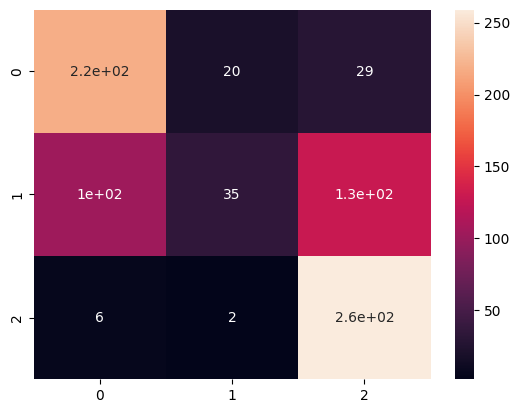

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_res['label'], lst)
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_res['label'], lst))

              precision    recall  f1-score   support

          -1       0.67      0.82      0.73       267
           0       0.61      0.13      0.22       267
           1       0.62      0.97      0.76       267

    accuracy                           0.64       801
   macro avg       0.63      0.64      0.57       801
weighted avg       0.63      0.64      0.57       801



In [49]:
len(y_res)

801

Transfer learning starts

In [12]:
res

[{'label': 'positive', 'score': 0.9729458689689636},
 {'label': 'positive', 'score': 0.47195905447006226},
 {'label': 'positive', 'score': 0.9092052578926086},
 {'label': 'positive', 'score': 0.9349462389945984},
 {'label': 'negative', 'score': 0.704387366771698},
 {'label': 'positive', 'score': 0.9879683256149292},
 {'label': 'positive', 'score': 0.5718432068824768},
 {'label': 'negative', 'score': 0.38137561082839966},
 {'label': 'positive', 'score': 0.9438472986221313},
 {'label': 'positive', 'score': 0.8422223329544067},
 {'label': 'positive', 'score': 0.9229409098625183},
 {'label': 'positive', 'score': 0.9773688316345215},
 {'label': 'positive', 'score': 0.9162188172340393},
 {'label': 'negative', 'score': 0.4987045228481293},
 {'label': 'positive', 'score': 0.5357362627983093},
 {'label': 'negative', 'score': 0.8982570767402649},
 {'label': 'positive', 'score': 0.9742113947868347},
 {'label': 'positive', 'score': 0.9745306968688965},
 {'label': 'positive', 'score': 0.89189577102

In [12]:
data_dic =  {"predicted_label": [], 'scores':[], 'true_label':[]}
for i in cp_res:
    if i['label'] == 'positive':
        data_dic['predicted_label'].append(1)
    elif i['label'] == 'negative':
        data_dic['predicted_label'].append(-1)
    elif i['label'] == 'neutral':
        data_dic['predicted_label'].append(0)
    else:
        print('wrong input')

    data_dic['scores'].append(i['score'])
    
for i in df['label']:
    data_dic['true_label'].append(i)
    

In [13]:
new_df = pd.DataFrame.from_dict(data_dic)

In [14]:
# new_df.to_csv('transfer_learn_data_new.csv')

In [15]:
new_df.columns

Index(['predicted_label', 'scores', 'true_label'], dtype='object')